#### 训练集：
	建议利用序号1-200图片
#### 测试集：
	建议利用序号201-236图片

### 项目要求：
	(1) 设计CNN神经网络模型，计算每张图片中煤的占比(煤炭在前景图像中的比例)
	(2) 撰写项目报告，主要包含如下章节结构
		Abstract：高度概括研究动机、思路、结果
		Introduction：研究背景与意义、主要创新点
		Related Research：相关研究调研
		Methods：采用的方法的详细说明，网络结构等
		Results：数据集，训练细节，在测试集上的实验结果等(ROC PR曲线)
		Conclusion


In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython



In [30]:
import os
from PIL import Image
from load_data import load_data

X_train,y_train,X_val,y_val,X_test,y_test = load_data()
X_test1 = np.copy(X_test)
print(X_train.shape)


(180, 512, 512, 3)


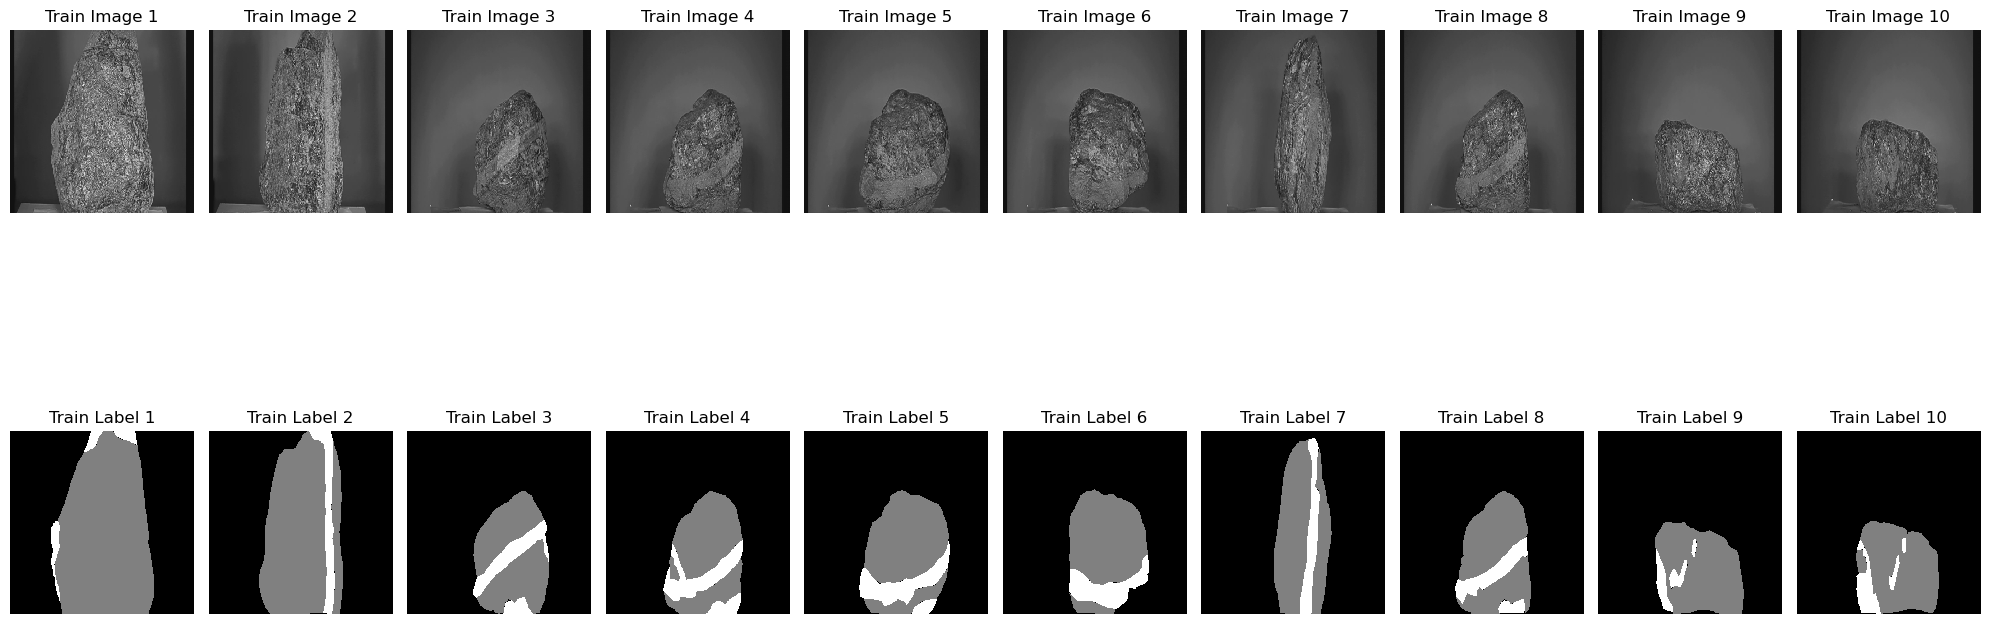

In [3]:
import matplotlib.pyplot as plt

# 设置显示大小
plt.figure(figsize=(20, 10))

# 展示前10个训练样本
for i in range(10):
    # 获取训练集中的图像和标签
    image = X_train[i]
    label = y_train[i]

    # 绘制图像
    plt.subplot(2, 10, i + 1)
    plt.imshow(image)
    plt.title(f'Train Image {i+1}')
    plt.axis('off')

    # 绘制标签
    plt.subplot(2, 10, i + 11)
    plt.imshow(label)
    plt.title(f'Train Label {i+1}')
    plt.axis('off')

# 调整子图间距
plt.subplots_adjust(wspace=0.2, hspace=0.3)

plt.tight_layout()
plt.show()


In [7]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np
from load_data import load_data

X_train,y_train,X_val,y_val,X_test,y_test = load_data()

# def print_arrays_containing_value(y_train, value=28):
#     # 遍历y_train中的每个子数组
#     for idx, y in enumerate(y_train):
#         if value in y:
#             print(f"Array index {idx} contains value {value}:\n{y}\n")


X_train = np.transpose(X_train, (0, 3, 1, 2))
X_val = np.transpose(X_val, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))
X_train_tensor = torch.FloatTensor(X_train)
Y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
Y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
Y_test_tensor = torch.LongTensor(y_test)

# 定义数据加载器
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from fcn import SimpleUNet

# 定义模型、损失函数和优化器
model = SimpleUNet(n_channels=3, n_classes=3)
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用Adam优化器

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, device, train_loader, optimizer, criterion, n_epochs, val_loader=None):
    train_losses = []  # 记录每个epoch的训练损失
    val_losses = []    # 记录每个epoch的验证损失
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        print(f'Epoch {epoch+1} Training Loss: {epoch_train_loss:.4f}')

        if val_loader is not None:
            val_loss = validate(model, device, val_loader, criterion)
            val_losses.append(val_loss)

    return train_losses, val_losses

def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.numel()
            correct += (predicted == labels).sum().item()
            print(correct)

    val_loss /= len(val_loader.dataset)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {correct}/ {total}/{accuracy:.2f}%')
    return val_loss

# 假设train_loader和val_loader是你的训练集和验证集数据加载器
train_losses, val_losses = train(model, device, train_loader, optimizer, criterion, n_epochs=10, val_loader=val_loader)

# 打印训练损失和验证损失的变化
print("Training Losses:")
for epoch, loss in enumerate(train_losses):
    print(f"Epoch {epoch+1}: {loss:.4f}")

print("\nValidation Losses:")
for epoch, loss in enumerate(val_losses):
    print(f"Epoch {epoch+1}: {loss:.4f}")



SimpleUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (up1): DoubleConv(
    (double_conv): Sequential(
      (0): Con

In [3]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'model_and_optimizer.pth')

In [9]:
import torch
import torch.nn as nn
from fcn import SimpleUNet
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型参数和优化器状态
checkpoint = torch.load('model_and_optimizer.pth')
model = SimpleUNet(n_channels=3, n_classes=3)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.to(device)  # 不要忘记将模型发送到正确的设备
model.eval()

SimpleUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (up1): DoubleConv(
    (double_conv): Sequential(
      (0): Con

=====原始label======
标签占比:
标签 背景: 90.56%
标签 煤: 7.27%
标签 煤矸石: 2.17%
煤矸石占比为: 0.23025651383558876
=====预测结果======
标签占比:
标签 背景: 90.80%
标签 煤: 8.48%
标签 煤矸石: 0.72%
煤矸石占比为: 0.07868009783194461


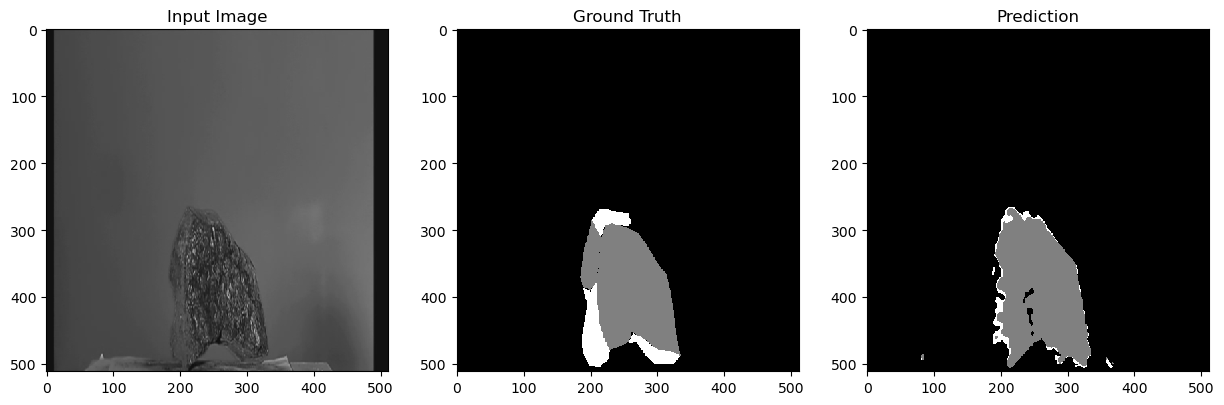

In [38]:
import matplotlib.pyplot as plt
import numpy as np
def label_mapping(label):
    if label==0:
        return "背景"
    elif label==1:
        return "煤"
    elif label==2:
        return "煤矸石"
    
    
def print_portion(prediction):
        # 计算预测结果中各标签的占比
    unique, counts = np.unique(prediction, return_counts=True)
    label_counts = dict(zip(unique, counts))
    total_pixels = prediction.size
    proportions = {label: count / total_pixels for label, count in label_counts.items()}

    # 打印标签占比
    print("标签占比:")
    for label1, proportion in proportions.items():
        print(f"标签 {label_mapping(label1)}: {proportion:.2%}")
    print(f"煤矸石占比为: {proportions[2]/(proportions[1]+proportions[2])}")
        
def visualize_prediction(model, data_loader,data_set, device):
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            pred = outputs.argmax(dim=1)
            
            # 选择一张图片来展示
            image = data_set[1]
            label = labels[1].cpu().numpy()
            prediction = pred[1].cpu().numpy()
            
            print("=====原始label======")
            print_portion(label)
            
            print("=====预测结果======")
            print_portion(prediction)

            # 可视化
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(image)
            ax[0].set_title('Input Image')
            ax[1].imshow(label)
            ax[1].set_title('Ground Truth')
            ax[2].imshow(prediction)
            ax[2].set_title('Prediction')
            plt.show()

            # 只展示第一张图片即可，退出循环
            break

# 测试并可视化结果
visualize_prediction(model, test_loader,X_test1, device)
